In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *
from utils import *

# torch._dynamo.config.suppress_errors = True

Load dataset:

In [2]:
data_size = 640_000
data_gen = single_random_ring(N=32)
X, y = data_gen.generate_dataset(data_size=data_size, noise=True, sigma=0.3, features_degree=2, seed=42, device='cpu', test_return=False)

In [3]:
data_gen.noise_delta

array({'mse_loss': {'mean': 0.0067056868433325876, 'std': 0.0019505400420071972}, 'l1_loss': {'mean': 0.025108530981164348, 'std': 0.006571911107567121}},
      dtype=object)

[[15.          9.          6.15        1.09        5.81194641  0.325     ]
 [ 9.         10.          6.39        0.9         2.67035376  0.24      ]
 [11.         23.          6.69        1.18        5.3014376   0.445     ]
 ...
 [10.          9.          8.58        1.32        3.80918109  0.27      ]
 [11.         20.          6.09        0.88        3.29867229  0.285     ]
 [11.         21.          7.71        1.14        5.7726765   0.12      ]]
[[0.         0.46666667 0.06666667 ... 0.86642142 0.61114288 0.43107846]
 [0.         0.06666667 0.13333333 ... 0.18290416 0.20735658 0.23507805]
 [0.         0.2        1.         ... 0.72089712 0.76329331 0.80818284]
 ...
 [0.         0.13333333 0.06666667 ... 0.37217673 0.33276158 0.29752066]
 [0.         0.2        0.8        ... 0.27910288 0.30417381 0.33149679]
 [0.         0.2        0.86666667 ... 0.85475258 0.22412807 0.05876951]]


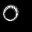

In [4]:
features, transformed_features, imgs = data_gen.random_sample(256)
print(features)
print(transformed_features)
Image.fromarray((imgs[0] * 255 / imgs[0].max()).astype(np.uint8))

Test generator:

In [5]:
# load generator
generator = DGBaNConv17()
# generator = torch.compile(generator)

pre_trained_weights = torch.load(
    '../save_data/single_random_ring/Adam_mse_loss_0/DGBaNConv17_no_activation_function/DGBaNConv17_no_activation_function_6.pt',
    map_location=torch.device('cpu')
)
generator.load_state_dict(pre_trained_weights)

print(generator.eval())
print(f'Number of parameters: {count_params(generator):,}')

DGBaNConv17(
  (linear_layers): NLinearNormAct(
    (linear_act): ModuleList(
      (0): LinearReparameterization()
      (1): ReLU()
      (2): LinearReparameterization()
      (3): ReLU()
      (4): LinearReparameterization()
      (5): ReLU()
      (6): LinearReparameterization()
      (7): ReLU()
      (8): LinearReparameterization()
      (9): ReLU()
    )
  )
  (conv_layers): BayesSequential(
    (bayes_modules): ModuleList(
      (0): BottleNeck(
        (block): ResidualAdd(
          (block): BayesSequential(
            (bayes_modules): ModuleList(
              (0-1): 2 x ConvNormAct(
                (conv): ConvTranspose2dReparameterization()
                (norm_act): Sequential(
                  (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (1): ReLU()
                )
              )
              (2): ConvNormAct(
                (conv): ConvTranspose2dReparameterization()
                (norm_act): Sequential

In [6]:
mse_loss = []
l1_loss = []
AbsMeanDelta = []
for i in range(1):
    y_pred = generator(torch.Tensor(transformed_features[:1]))[0].detach().numpy().squeeze()
    mse_loss.append(((y_pred - imgs[0])**2).mean())
    l1_loss.append(abs(y_pred - imgs[0]).mean())
    AbsMeanDelta.append(abs((y_pred - imgs[0]).mean()))

print(np.mean(mse_loss))
print(np.mean(l1_loss))
print(np.mean(AbsMeanDelta))

0.0163657338583394
0.04584448765021619
0.0348517962344742


In [7]:
# setting the base feature
n_samples = 100

# getting the predictions for this feature
pred_rings = np.zeros((n_samples, 32, 32))
with torch.no_grad():
    for j in range(n_samples):
        pred_rings[j] += generator(torch.Tensor(transformed_features[:1]))[0].detach().numpy().squeeze()
pred_ring = pred_rings.mean(axis=0)

# summing the predictions
pred_prob = pred_ring * 255
true_prob = data_gen.ring_from_features(*features[0]) * 255 / 2

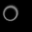

In [8]:
# predicted gaussian ring
Image.fromarray(abs(pred_prob).astype(np.uint8))

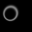

In [9]:
# true gaussian ring
Image.fromarray(true_prob.astype(np.uint8))

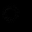

In [10]:
# difference between the rings
Image.fromarray(np.abs(true_prob - pred_prob).astype(np.uint8))

In [11]:
# MSE error
((pred_prob / pred_prob.max() - true_prob / true_prob.max())**2).mean()

0.00013123983810410097

(8, 6)


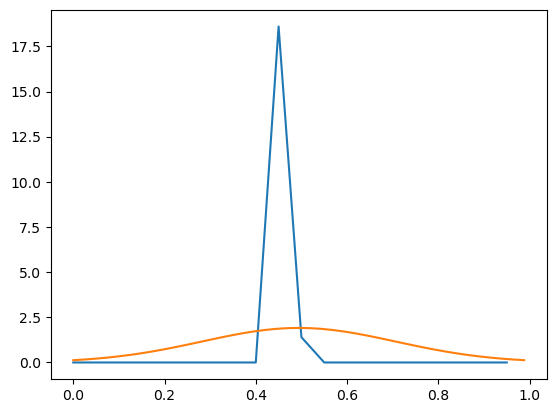

In [12]:
# getting the distribution for one pmt
pmt = (0, 0)
while true_prob[pmt] < 0.4 * 255:
    pmt = (np.random.randint(32), np.random.randint(32))
print(pmt)

hist_width = 0.05
pred = pd.Series(pred_rings[:, pmt[0], pmt[1]])
hist = pd.Series(1, index=pd.cut(pred, np.arange(0, 1.01, hist_width))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * hist_width)

plt.plot(np.arange(0, 1, hist_width), pred_noise)

val = np.arange(0, 2.01, hist_width) * true_prob[pmt] / 255
true_pmt_distr = np.exp(-(val - true_prob[pmt] / 255)**2 / 0.3**2)
true_pmt_distr /= true_pmt_distr.sum() * hist_width * true_prob[pmt] / 255
plt.plot(val, true_pmt_distr)
plt.show()